# Basic Tutorial

Trey V. Wenger (c) July 2024

Here we demonstrate the basic features of a `bayes_spec` model.

In [1]:
# General imports
from IPython.display import SVG, display
    
import os
import pickle

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

# Notebook configuration
pd.options.display.max_rows = None

# plot directory and extension
figdir = "figures"
ext = "svg"
if not os.path.isdir(figdir):
    os.mkdir(figdir)
    
# random state
rng = np.random.RandomState(seed=1234)

bayes_spec version: 1.2.0


## Model Definition

First, we define our model. Here we demonstrate a simple Gaussian line profile model where each "cloud" is expected to produce one Gaussian features. We follow "good" practices by ensuring that the free parameters of the model are normalized so that we are able to efficiently sample the parameter space later. To define a model, we extend the `bayes_spec.BaseModel` class. This class must have two methods: `__init__` and `define`. For convenience, we've also defined a `predict` function, which will make simulating observations from this model a breeze. This model is copied directly from `bayes_spec.models.gauss_line.py`.

In [2]:
from typing import Iterable

from bayes_spec import BaseModel
from bayes_spec.utils import gaussian


class GaussLine(BaseModel):
    """
    Definition of a Gaussian line profile model.
    """

    def __init__(self, *args, **kwargs):
        """
        Define model parameters, deterministic quantities, posterior
        clustering features, and TeX parameter representations.

        Inputs: see bayes_spec.BaseModel

        Returns: new GaussLine instance
        """
        # Initialize BaseModel
        super().__init__(*args, **kwargs)

        # Define (normalized) cloud free parameter names
        self.cloud_params += [
            "line_area_norm",
            "fwhm_norm",
            "velocity_norm",
        ]

        # Define deterministic quantities (including un-normalized cloud free parameters)
        self.deterministics += [
            "line_area",
            "fwhm",
            "velocity",
            "amplitude",
        ]

        # Select features used for posterior clustering
        self._cluster_features += [
            "velocity",
            "line_area",
        ]

        # Define TeX representation of each parameter
        self.var_name_map.update(
            {
                "line_area": r"$\int\!T_B\,dV$ (K km s$^{-1}$)",
                "fwhm": r"$\Delta V$ (km s$^{-1}$)",
                "velocity": r"$V_{\rm LSR}$ (km s$^{-1}$)",
                "amplitude": r"$T_B$ (K)",
            }
        )

    def define(
        self,
        prior_line_area: float = 100.0,
        prior_fwhm: float = 25.0,
        prior_velocity: Iterable[float] = [0.0, 25.0],
        prior_baseline_coeff: float = 1.0,
    ):
        """
        Model definition. The SpecData key must be "observation".

        Inputs:
            prior_line_area :: scalar
                Prior distribution on line area (K km s-1), where:
                line_area ~ Gamma(alpha=2.0, beta=1.0/prior_line_area)
            prior_fwhm :: scalar
                Prior distribution on line area (K km s-1), where:
                line_area ~ Gamma(alpha=2.0, beta=1.0/prior_line_area)
                Mode of the k=2 gamma distribution Gaussian FWHM line width prior
            prior_vlsr :: two-element array of scalars
                Prior distribution on line centroid velocity (km s-1), where:
                velocity ~ Normal(mu=prior_velocity[0], sigma=prior_velocity[1])
            prior_baseline_coeff :: scalar
                Prior distribution on normalized polynomial baseline coefficients, where:
                coeff ~ Normal(mu=0, sigma=prior_baseline_coeffs)

        Returns: Nothing
        """
        # add polynomial baseline priors
        super().add_baseline_priors(prior_baseline_coeff=prior_baseline_coeff)

        with self.model:
            # Line area per cloud
            line_area_norm = pm.Gamma(
                "line_area_norm", alpha=2.0, beta=1.0, dims="cloud"
            )
            line_area = pm.Deterministic(
                "line_area", prior_line_area * line_area_norm, dims="cloud"
            )

            # FWHM line width per cloud
            fwhm_norm = pm.Gamma(
                "fwhm_norm",
                alpha=2.0,
                beta=1.0,
                dims="cloud",
            )
            fwhm = pm.Deterministic("fwhm", prior_fwhm * fwhm_norm, dims="cloud")

            # Centroid velocity per cloud
            velocity_norm = pm.Normal(
                "velocity_norm",
                mu=0.0,
                sigma=1.0,
                dims="cloud",
            )
            velocity = pm.Deterministic(
                "velocity",
                prior_velocity[0] + prior_velocity[1] * velocity_norm,
                dims="cloud",
            )

            # Deterministic amplitude per cloud
            amplitude = pm.Deterministic(
                "amplitude",
                line_area / fwhm / np.sqrt(np.pi / (4.0 * np.log(2.0))),
                dims="cloud",
            )

            # Predict spectrum
            predicted = self.predict(amplitude, velocity, fwhm)

            # Evaluate likelihood
            _ = pm.Normal(
                "observation",
                mu=predicted,
                sigma=self.data["observation"].noise,
                observed=self.data["observation"].brightness,
            )

    def predict(self, amplitude, velocity, fwhm):
        """
        Model definition. The SpecData key must be "observation".

        Inputs:
            amplitude :: 1-D array of scalars
                Gaussian ampltiudes (K)
            velocity :: 1-D array of scalars
                Gaussian centroid velocities (km s-1)
            fwhm :: 1-D array of scalars
                Gaussian FWHM line widths (km/s)

        Returns:
            predicted :: 1-D array of scalars
                Predicted spectrum (un-normalized)
        """
        # Evaluate line profile model per cloud, sum over clouds
        predicted_line = gaussian(
            self.data["observation"].spectral[:, None], amplitude, velocity, fwhm
        ).sum(axis=1)

        # Add baseline model
        baseline_models = self.predict_baseline()
        predicted = predicted_line + baseline_models["observation"]
        return predicted


## Data Format

We wish to generate some synthetic data from our model, which requires us to take a brief aside to introduce the `bayes_spec` data format. We use the `SpecData` class to pass data into `bayes_spec`.

In [3]:
from bayes_spec import SpecData

# spectral axis definition
velocity_axis = np.linspace(-250.0, 250.0, 501) # km/s

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = np.random.randn(len(velocity_axis)) # K

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 1.0 # K

# Our model only expects a single observation named "observation"
# Note that because we "named" the spectrum "observation" here,
# we must use the same name in the model definition above
observation = SpecData(
    velocity_axis,
    brightness_data,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

## Simulating Data

Now that we have a model definition and a dummy data format, we can generate simulated observations by drawing samples from the parameter prior distributions.

Sampling: [fwhm_norm, line_area_norm, observation, observation_baseline_norm, velocity_norm]


Text(0, 0.5, 'Brightness Temperature (K)')

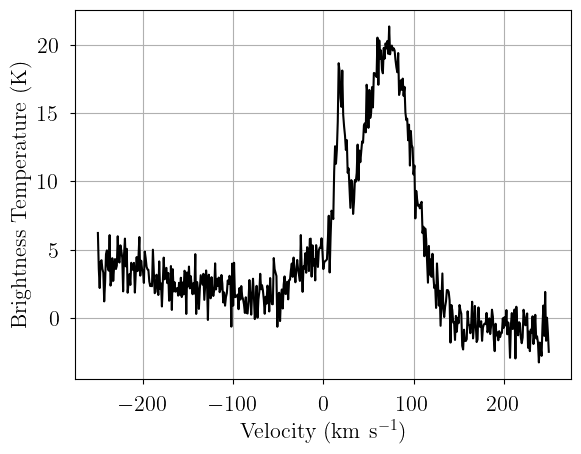

In [4]:
# Initialize and define the model
model = GaussLine(dummy_data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.define(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeff = 1.0, # width of normal distribution prior on normalized baseline coefficients
)

# Draw one posterior predictive sample
simulated = model.prior_predictive_check(
    samples=1,
)
sim_brightness = simulated.prior_predictive["observation"].sel(chain=0, draw=0).data

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

Alternatively, we can pass the relevant parameters directly to the likelihood variable, named `observation` in our model, to evaluate a model with specific model parameters. Be sure that the simulated values are reasonable given your prior distributions!

Text(0, 0.5, 'Brightness Temperature (K)')

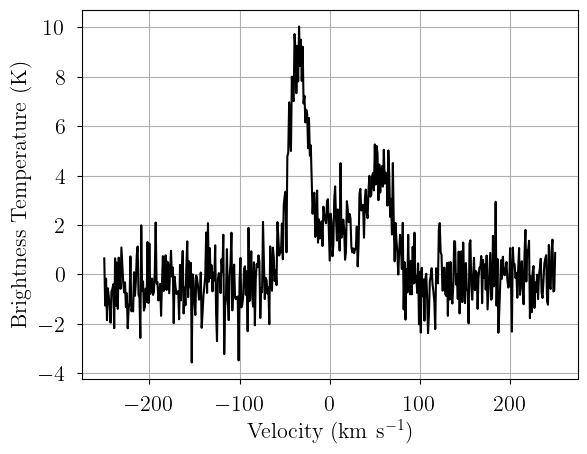

In [5]:
sim_brightness = model.model.observation.eval({
    "fwhm": [25.0, 40.0, 35.0], # FWHM line width (km/s)
    "line_area": [250.0, 125.0, 175.0], # line area (K km/s)
    "velocity": [-35.0, 10.0, 55.0], # velocity (km/s)
    "observation_baseline_norm": [-0.5, 0.2, 0.05], # normalized baseline coefficients
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

In [6]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    velocity_axis,
    sim_brightness,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## Model

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `bayes_spec`.

We begin with a three-cloud (`n_cloud=3`) model, with a 2nd order polynomial baseline (`baseline_degree=2`).

In [7]:
model = GaussLine(data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.define(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeff = 1.0, # width of normal distribution prior on normalized baseline coefficients
)

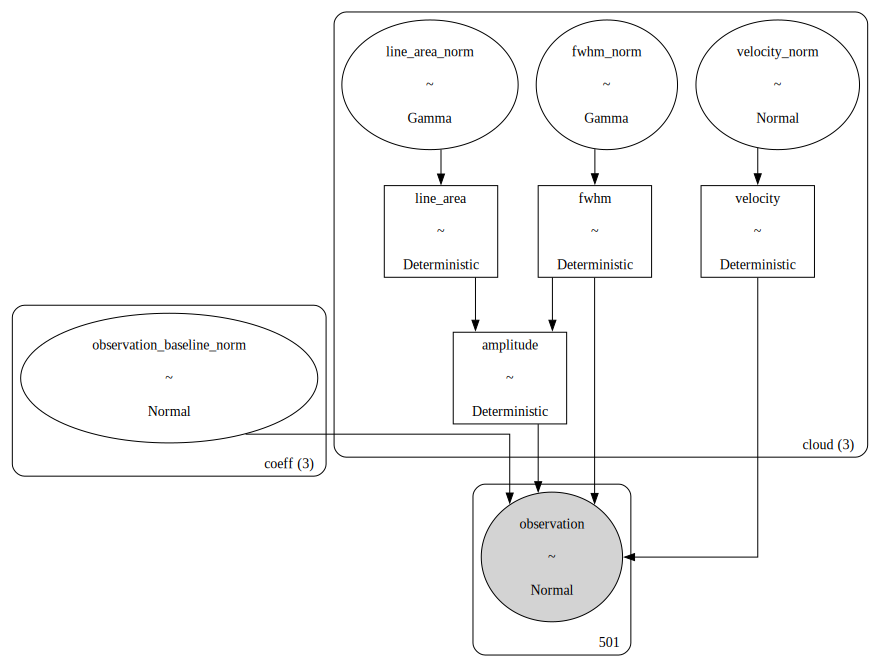

In [8]:
# Plot model graph
model.plot_graph(f"{figdir}/model.gv", "svg")
SVG(f"{figdir}/model.gv.{ext}")

In [9]:
# model string representation
print(model.model.str_repr())

observation_baseline_norm ~ Normal(0, 1)
           line_area_norm ~ Gamma(2, f())
                fwhm_norm ~ Gamma(2, f())
            velocity_norm ~ Normal(0, 1)
                line_area ~ Deterministic(f(line_area_norm))
                     fwhm ~ Deterministic(f(fwhm_norm))
                 velocity ~ Deterministic(f(velocity_norm))
                amplitude ~ Deterministic(f(fwhm_norm, line_area_norm))
              observation ~ Normal(f(fwhm_norm, line_area_norm, observation_baseline_norm, velocity_norm), <constant>)


We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [fwhm_norm, line_area_norm, observation, observation_baseline_norm, velocity_norm]


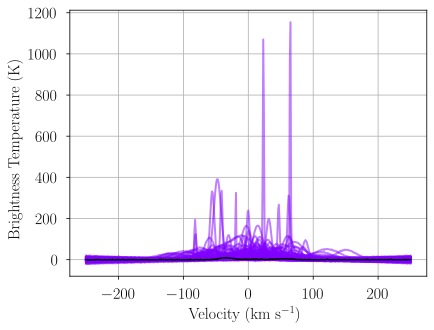

In [10]:
# prior predictive check
prior = model.prior_predictive_check(
    samples=100,  # prior predictive samples
    plot_fname=f"{figdir}/prior_predictive.{ext}",
)
SVG(f"{figdir}/prior_predictive.{ext}")

We can also generate a pair plot to inspect the prior distributions and their effect on deterministic quantities. The model has attributes `cloud_params` for cloud free parameters, `deterministics` for deterministic quantities, `baseline_params` for the free polynomial baseline parameters, and `hyper_params` for the hyperparameters. Here we show the pair plot for the deterministic quantities derived from our prior distributions.

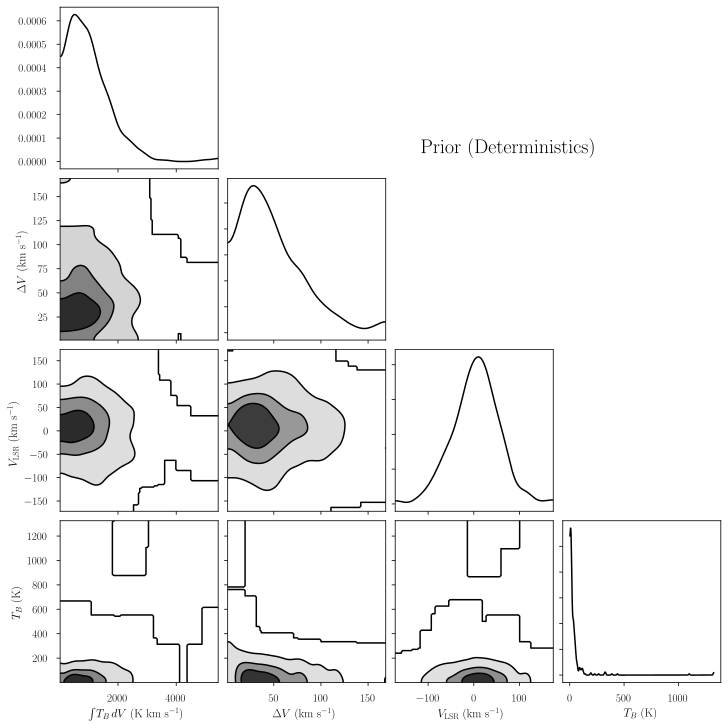

In [11]:
from bayes_spec.plots import plot_pair

plot_pair(
    prior.prior, # samples
    model.deterministics, # var_names to plot
    "Prior (Deterministics)", # plot label
    f"{figdir}/pair_prior_determ.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
SVG(f"{figdir}/pair_prior_determ.{ext}")

## Posterior Sampling: Variational Inference

We can approximate the posterior distribution using variational inference (VI). We will run a maximum of `n` iterations, but stop early if it appears that VI has converged on a solution. You will have to tune the convergence thresholds and learning rate for your model.

In [12]:
model.fit(
    n = 500_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.01, # VI absolute convergence threshold
    learning_rate = 1e-3, # VI learning rate
)

Output()

Convergence achieved at 37500
Interrupted at 37,499 [7%]: Average Loss = 4,135.5


In [13]:
# posterior samples stored in model.trace.posterior
az.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean      sd   hdi_3%  hdi_97%  mcse_mean  \
amplitude[0]                    2.351   0.238    1.921    2.772      0.007   
amplitude[1]                    8.273   0.427    7.414    9.011      0.013   
amplitude[2]                    4.222   0.342    3.541    4.794      0.011   
fwhm[0]                        73.213   5.513   63.204   83.777      0.172   
fwhm[1]                        22.502   0.873   20.781   23.986      0.027   
fwhm[2]                        30.941   1.928   27.669   34.679      0.063   
fwhm_norm[0]                    2.929   0.221    2.528    3.351      0.007   
fwhm_norm[1]                    0.900   0.035    0.831    0.959      0.001   
fwhm_norm[2]                    1.238   0.077    1.107    1.387      0.003   
line_area[0]                  182.173  12.475  156.961  203.561      0.393   
line_area[1]                  197.872   6.748  185.708  209.998      0.202   
line_area[2]                  138.539   7.432  124.745  152.054      0.254   
line_area_norm[0]               0.364   0.025    0.314    0.407      0.001   
line_area_norm[1]               0.396   0.013    0.371    0.420      0.000   
line_area_norm[2]               0.277   0.015    0.249    0.304      0.001   
observation_baseline_norm[0]   -0.483   0.022   -0.529   -0.443      0.001   
observation_baseline_norm[1]    0.057   0.022    0.019    0.102      0.001   
observation_baseline_norm[2]    0.012   0.017   -0.019    0.043      0.001   
velocity[0]                     1.291   3.260   -5.052    7.179      0.105   
velocity[1]                   -35.203   0.637  -36.318  -33.964      0.020   
velocity[2]                    56.162   1.253   53.811   58.471      0.038   
velocity_norm[0]                0.026   0.065   -0.101    0.144      0.002   
velocity_norm[1]               -0.704   0.013   -0.726   -0.679      0.000   
velocity_norm[2]                1.123   0.025    1.076    1.169      0.001   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
amplitude[0]                    0.005    1044.0     975.0    NaN  
amplitude[1]                    0.009    1091.0     856.0    NaN  
amplitude[2]                    0.008     964.0     897.0    NaN  
fwhm[0]                         0.122    1010.0     795.0    NaN  
fwhm[1]                         0.019    1075.0    1025.0    NaN  
fwhm[2]                         0.044     948.0     983.0    NaN  
fwhm_norm[0]                    0.005    1010.0     795.0    NaN  
fwhm_norm[1]                    0.001    1075.0    1025.0    NaN  
fwhm_norm[2]                    0.002     948.0     983.0    NaN  
line_area[0]                    0.278    1010.0    1031.0    NaN  
line_area[1]                    0.143    1112.0     837.0    NaN  
line_area[2]                    0.180     845.0    1021.0    NaN  
line_area_norm[0]               0.001    1010.0    1031.0    NaN  
line_area_norm[1]               0.000    1112.0     837.0    NaN  
line_area_norm[2]               0.000     845.0    1021.0    NaN  
observation_baseline_norm[0]    0.001     949.0     981.0    NaN  
observation_baseline_norm[1]    0.001     909.0     851.0    NaN  
observation_baseline_norm[2]    0.000     976.0     788.0    NaN  
velocity[0]                     0.076     949.0     961.0    NaN  
velocity[1]                     0.014     969.0    1070.0    NaN  
velocity[2]                     0.027    1093.0    1014.0    NaN  
velocity_norm[0]                0.002     949.0     961.0    NaN  
velocity_norm[1]                0.000     969.0    1070.0    NaN  
velocity_norm[2]                0.001    1093.0    1014.0    NaN

It's good practice to verify the integrity of your solution! Here we generate posterior predictive checks -- realizations of the model drawn with parameters drawn from the posterior distribution. Each line is one posterior sample.

Sampling: [observation]


Output()

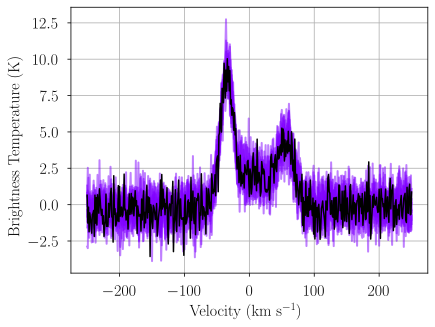

In [14]:
posterior_predictive = model.posterior_predictive_check(
    thin=100, plot_fname=f"{figdir}/posterior_predictive_vi.{ext}"
)
SVG(f"{figdir}/posterior_predictive_vi.{ext}")

## Posterior Sampling: MCMC

VI is fast, but it's not particularly accurate, and there is no way to diagnose "convergence". Instead, we sample the posterior distribution using MCMC. Here we initialize the No U-Turn Sampler (NUTS) using VI (also available is the `pymc` default: `init="jitter+adapt_diag"`, which may be better suited to some models). We can customize the VI initialization as well as the NUTS parameters. If there are many divergences, or if the resulting effective sample sizes are small and `r_hat` is large, try increasing the number of tuning samples, draws, and/or chains. Increasing `target_accept` to `0.9` or `0.95` can help if there are many divergences. Use as many chains as possible.

In [15]:
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.01, "learning_rate": 1e-3}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 37500
Interrupted at 37,499 [7%]: Average Loss = 4,135.5
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


If a chain does not converge, an error is printed and that chain is dropped from all subsequent analyses. In the remaining chains, there may be some divergences. The number of divergences should be much less than the number of posterior samples.

In general, there could be a labeling degeneracy, or multiple unique solutions. Here we "solve" for those effects using a Gaussian Mixture Model (GMM). The parameter `p_threshold` defines the probability threshold for "unique" GMM solutions.

In [16]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


In [17]:
print("solutions:", model.solutions)
display(az.summary(model.trace["solution_0"]))
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


mean      sd   hdi_3%  hdi_97%  mcse_mean  \
amplitude[0]                    2.440   0.230    2.013    2.881      0.005   
amplitude[1]                    8.438   0.531    7.531    9.475      0.016   
amplitude[2]                    4.256   0.368    3.575    4.951      0.009   
fwhm[0]                        65.622  16.093   34.731   91.778      0.555   
fwhm[1]                        23.147   1.506   20.324   25.858      0.043   
fwhm[2]                        31.182   2.909   26.164   37.057      0.070   
fwhm_norm[0]                    2.625   0.644    1.389    3.671      0.022   
fwhm_norm[1]                    0.926   0.060    0.813    1.034      0.002   
fwhm_norm[2]                    1.247   0.116    1.047    1.482      0.003   
line_area[0]                  169.750  42.959   93.311  246.158      1.477   
line_area[1]                  208.277  22.465  168.595  248.915      0.770   
line_area[2]                  141.464  19.330  104.140  175.123      0.570   
line_area_norm[0]               0.340   0.086    0.187    0.492      0.003   
line_area_norm[1]               0.417   0.045    0.337    0.498      0.002   
line_area_norm[2]               0.283   0.039    0.208    0.350      0.001   
observation_baseline_norm[0]   -0.486   0.053   -0.584   -0.387      0.001   
observation_baseline_norm[1]    0.058   0.021    0.020    0.098      0.000   
observation_baseline_norm[2]    0.014   0.032   -0.047    0.071      0.001   
velocity[0]                     3.168   5.528   -7.168   13.668      0.154   
velocity[1]                   -35.039   0.459  -35.868  -34.159      0.010   
velocity[2]                    55.753   1.270   53.316   58.151      0.032   
velocity_norm[0]                0.063   0.111   -0.143    0.273      0.003   
velocity_norm[1]               -0.701   0.009   -0.717   -0.683      0.000   
velocity_norm[2]                1.115   0.025    1.066    1.163      0.001   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
amplitude[0]                    0.003    2444.0    3082.0    1.0  
amplitude[1]                    0.011    1105.0    2087.0    1.0  
amplitude[2]                    0.006    1627.0    2544.0    1.0  
fwhm[0]                         0.393     884.0    1471.0    1.0  
fwhm[1]                         0.031    1206.0    2076.0    1.0  
fwhm[2]                         0.050    1707.0    2167.0    1.0  
fwhm_norm[0]                    0.016     884.0    1471.0    1.0  
fwhm_norm[1]                    0.001    1206.0    2076.0    1.0  
fwhm_norm[2]                    0.002    1707.0    2167.0    1.0  
line_area[0]                    1.045     850.0    1521.0    1.0  
line_area[1]                    0.548     865.0    1636.0    1.0  
line_area[2]                    0.404    1154.0    1817.0    1.0  
line_area_norm[0]               0.002     850.0    1521.0    1.0  
line_area_norm[1]               0.001     865.0    1636.0    1.0  
line_area_norm[2]               0.001    1154.0    1817.0    1.0  
observation_baseline_norm[0]    0.001    1949.0    1676.0    1.0  
observation_baseline_norm[1]    0.000    5345.0    3035.0    1.0  
observation_baseline_norm[2]    0.001    2116.0    1999.0    1.0  
velocity[0]                     0.109    1343.0    1810.0    1.0  
velocity[1]                     0.007    2265.0    2658.0    1.0  
velocity[2]                     0.022    1663.0    2248.0    1.0  
velocity_norm[0]                0.002    1343.0    1810.0    1.0  
velocity_norm[1]                0.000    2265.0    2658.0    1.0  
velocity_norm[2]                0.000    1663.0    2248.0    1.0

We again generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color, and the "thin" lines are the contributions of individual clouds. Each line is one posterior sample.

Sampling: [observation]


Output()

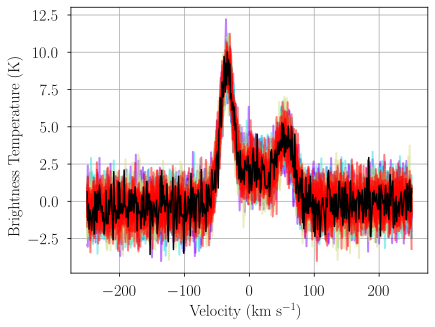

In [18]:
posterior_predictive = model.posterior_predictive_check(
    thin=100, plot_fname=f"{figdir}/posterior_predictive.{ext}"
)
SVG(f"{figdir}/posterior_predictive.{ext}")

In [19]:
model.plot_traces(f"{figdir}/traces.{ext}")
SVG(f"{figdir}/traces.{ext}")

We can inspect the posterior distribution pair plots. First, the (deterministic) cloud parameters.

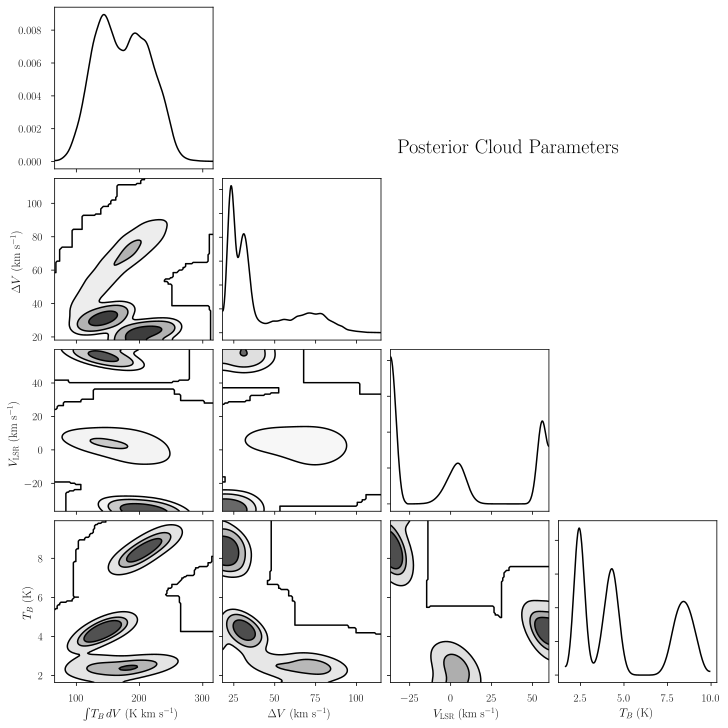

In [20]:
plot_pair(
    model.trace.solution_0, # samples
    model.deterministics, # var_names to plot
    "Posterior Cloud Parameters", # plot label
    f"{figdir}/pair_posterior_cloud_params.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
SVG(f"{figdir}/pair_posterior_cloud_params.{ext}")

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions for a single cloud.

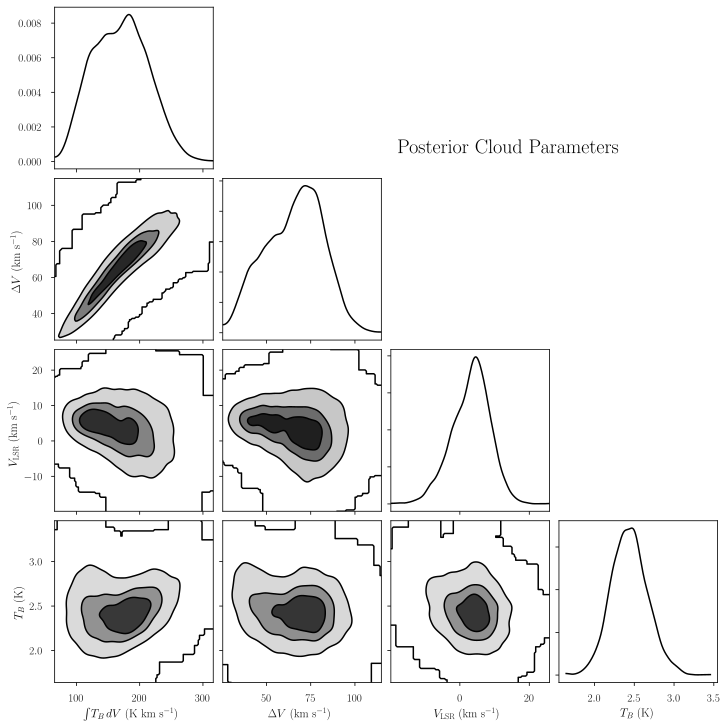

In [21]:
plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.deterministics, # var_names to plot
    "Posterior Cloud Parameters", # plot label
    f"{figdir}/pair_posterior_cloud_params_0.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
SVG(f"{figdir}/pair_posterior_cloud_params_0.{ext}")

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [22]:
point_stats = az.summary(model.trace.solution_0, var_names=model.deterministics, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: 1500.2398853370958


mean      sd  hdi_16%  hdi_84%
line_area[0]  169.750  42.959  122.475  213.258
line_area[1]  208.277  22.465  180.766  228.416
line_area[2]  141.464  19.330  123.286  161.933
fwhm[0]        65.622  16.093   52.362   86.178
fwhm[1]        23.147   1.506   21.620   24.642
fwhm[2]        31.182   2.909   28.081   33.716
velocity[0]     3.168   5.528   -1.439    9.243
velocity[1]   -35.039   0.459  -35.514  -34.608
velocity[2]    55.753   1.270   54.561   57.003
amplitude[0]    2.440   0.230    2.195    2.642
amplitude[1]    8.438   0.531    7.841    8.944
amplitude[2]    4.256   0.368    3.889    4.623